# REINFORCE

a.k.a. Vanilla Policy Gradient

- PG 의 그라디언트는 policy 의 expected reward 를 objective function 으로 갖는다. 따라서, objective function 을 maximize 해야 함

Algorithm:

```py
# initialize theta (net) & b (baseline)
init(net, b)
for iteration in (1, 2, ...):
    trajectory = env.play(net) # sample action from policy probs
    R = 0
    pg_loss = 0
    b_mse = 0
    for t, (s, a, r) in enumerate(trajectory[::-1]):
        R += r
        # calc policy gradients
        A = R - b(s)
        log_prob = log(net(s)[a]) # pi(a|s)
        pg_loss += -log_prob * A # we have to maximize J, or minimize -J.
        # calc baseline loss
        b_mse += (b(s) - R) ** 2
        R *= gamma
    minimize(pg_loss)
    minimize(b_mse)
    net.step() # update accumulated gradients
```

## With baseline

- Value function 을 학습하여 baseline 으로 사용.
- Actor-Critic 의 critic 개념이며, 다만 TD 로 학습하지 않고 MC 로 학습하는 것이 REINFORCE with Baseline.

## vs. Actor-Critic

- REINFORCE with baseline 의 TD 버전이 Actor-Critic 이다.
    - REINFORCE with baseline 는 policy 를 학습할 때에도, baseline 을 학습할 때에도 MC.
    - 반대로 Actor-Critic 은 actor(policy)/critic(baseline) 모두 TD 로 학습.

## Think about Value function

생각해 보면 value function 이 V(s) 가 state s 에 대한 '가치' 를 나타낼 것 같지만 조금 다르다.

Value function 의 정의는 expected return 이다. 즉, state s 로부터 기대할 수 있는 return 을 나타내는 값이고, 이 return 은 state s 에서부터 시작하여 에피소드가 끝날 때 까지 받을 수 있는 리워드의 합이다. 즉, value function V(s) 는 state s 에 대한 가치가 아니라 state s 에서부터 시작해서 앞으로 기대할 수 있는 가치 (return) 다.

그게 그거인것처럼 보일 수 있지만 사실 다르다. V(s) 는 현재 state 의 가치를 고려하는 것이 아니라, 앞으로 기대할 수 있는 return 의 가치만 고려한다는 것이다. 즉, 현재 state 가 아무리 가치있어도 앞으로 기대할 수 있는 return 이 좋지 않으면 V(s) 는 낮아지게 된다. 

물론 이것은 리워드 디자인을 어떻게 하느냐에 따라 달라질 수 있다. 만약 모든 리워드가 에피소드 종료 후에 주어진다면, 현재 state 가 가치있는 것이 앞으로 기대할 수 있는 return 에 큰 영향을 미칠 것이므로 위 얘기가 별 의미가 없게 된다. 하지만 잘 생각해보자 - 재미있는 케이스들이 있으니.

**Example**

로또를 맞고 돈을 흥청망청 쓰는 케이스를 생각해보자. V(로또를 맞기 직전 상태) 는 앞으로 로또를 맞을 것이므로 expected return 이 엄청나게 클 것이다. 하지만 V(로또를 맞은 상태) 는 로또를 이미 맞았으므로 앞으로 돈 쓸 일만 남아서 expected return 이 오히려 - 가 된다!

In [1]:
%matplotlib inline
import collections
import random
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')

In [3]:
SEED = 4
env.seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
env.observation_space

Box(4,)

In [5]:
env.action_space

Discrete(2)

In [6]:
class Policy(nn.Module):
    def __init__(self, n_state, n_action, n_hidden=64):
        """ 2-hidden layer NN
        n_obs: # of state
        n_action: # of actions
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_state, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_action)
        )
    
    def forward(self, x):
        return F.softmax(self.net(x))

In [7]:
class Baseline(nn.Module):
    def __init__(self, n_state, n_hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_state, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, 1)
        )
    
    def forward(self, x):
        return self.net(x)

In [8]:
observation = env.reset()

In [9]:
observation

array([ 0.02543978,  0.02580473, -0.00815877,  0.01237681])

In [10]:
n_episode = 500
device = torch.device("cuda")
policy = Policy(env.observation_space.shape[0], env.action_space.n).to(device)
baseline = Baseline(env.observation_space.shape[0]).to(device)

# for n, p in baseline.named_parameters():
#     if p.dim() == 2: # weights
#         nn.init.normal_(p, std=1e-1)
#     elif p.dim() == 1: # bias
#         nn.init.normal_(p, std=1e-3)
#         # nn.init.zeros_(p)

gamma = 0.99

p_optim = torch.optim.Adam(policy.parameters(), lr=0.001)
b_optim = torch.optim.Adam(baseline.parameters(), lr=0.001)

rewards = []
losses = []

# initialize theta (net) & b (baseline)
for episode in range(n_episode):
    traj = []
    state = env.reset()
    done = False
    total_reward = 0
    # play
    while not done:
        # get action
        state = torch.FloatTensor(state).to(device)
        action_prob = policy(state)
        action_prob_dist = torch.distributions.Categorical(action_prob)
        action = action_prob_dist.sample()
        
        b = baseline(state)
        
        next_state, reward, done, info = env.step(action.item())
        
        log_prob = action_prob_dist.log_prob(action)
        traj.append((log_prob, reward, b))
        total_reward += reward
        
        state = next_state
    
    rewards.append(total_reward)
    
    # calc loss
    R = 0.
    loss = 0.
    b_mse = 0.
    for (log_prob, reward, b) in traj[::-1]:
        R += reward
        # No baseline gradient flow to policy gradient
        A = R - b.detach()
        
        # pg loss
        pg_loss = -log_prob * A
        loss += pg_loss
        
        # baseline loss
        b_mse += (b - R) ** 2
        
        # discount
        R *= gamma
    
    losses.append((loss, b_mse))
    
    p_optim.zero_grad()
    # [!] why retain_graph is required?
    # baseline b 를 pg_loss 계산할때도 쓰고 b_mse 계산할때도 쓰니까 그런것
    # 근데 생각해보면 pg_loss 에서는 그라디언트가 흘러가면 안 될 듯 => 상관은 없는데 이론하고 조금 달라짐..
#     loss.backward(retain_graph=True)
    loss.backward()
    p_optim.step()

    b_optim.zero_grad()
    b_mse.backward()
    b_optim.step()
    
    print("[EP {:4d}] Reward = {}. Loss = {}, Baseline MSE = {}".format(
        episode, total_reward, loss.item(), b_mse.item()))

/home1/irteam/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[EP    0] Reward = 19.0. Loss = 122.3607406616211, Baseline MSE = 2199.987548828125
[EP    1] Reward = 21.0. Loss = 151.03663635253906, Baseline MSE = 2885.746826171875
[EP    2] Reward = 10.0. Loss = 33.77708435058594, Baseline MSE = 367.6009521484375
[EP    3] Reward = 81.0. Loss = 1782.98583984375, Baseline MSE = 103348.0703125
[EP    4] Reward = 13.0. Loss = 58.56602478027344, Baseline MSE = 754.6769409179688
[EP    5] Reward = 26.0. Loss = 225.40830993652344, Baseline MSE = 5160.673828125
[EP    6] Reward = 21.0. Loss = 147.93801879882812, Baseline MSE = 2857.63671875
[EP    7] Reward = 36.0. Loss = 400.9862976074219, Baseline MSE = 12504.7333984375
[EP    8] Reward = 17.0. Loss = 99.18856048583984, Baseline MSE = 1579.3590087890625
[EP    9] Reward = 26.0. Loss = 216.74871826171875, Baseline MSE = 5124.6884765625
[EP   10] Reward = 12.0. Loss = 50.773746490478516, Baseline MSE = 588.1956176757812
[EP   11] Reward = 36.0. Loss = 399.0010986328125, Baseline MSE = 12453.349609375
[E

[EP  100] Reward = 55.0. Loss = 611.8739013671875, Baseline MSE = 26922.919921875
[EP  101] Reward = 78.0. Loss = 1176.049560546875, Baseline MSE = 71484.1875
[EP  102] Reward = 134.0. Loss = 3182.645263671875, Baseline MSE = 269813.8125
[EP  103] Reward = 29.0. Loss = 149.03369140625, Baseline MSE = 3392.3427734375
[EP  104] Reward = 46.0. Loss = 391.431884765625, Baseline MSE = 15123.3837890625
[EP  105] Reward = 50.0. Loss = 473.0152587890625, Baseline MSE = 19220.595703125
[EP  106] Reward = 80.0. Loss = 1308.1705322265625, Baseline MSE = 70596.09375
[EP  107] Reward = 47.0. Loss = 427.8203125, Baseline MSE = 15456.4150390625
[EP  108] Reward = 53.0. Loss = 547.9847412109375, Baseline MSE = 21896.46484375
[EP  109] Reward = 41.0. Loss = 281.3131103515625, Baseline MSE = 10017.5341796875
[EP  110] Reward = 52.0. Loss = 490.0924987792969, Baseline MSE = 20351.240234375
[EP  111] Reward = 63.0. Loss = 773.1861572265625, Baseline MSE = 34450.4609375
[EP  112] Reward = 51.0. Loss = 455.

[EP  202] Reward = 164.0. Loss = 799.797607421875, Baseline MSE = 126744.1953125
[EP  203] Reward = 200.0. Loss = 1754.8739013671875, Baseline MSE = 199259.578125
[EP  204] Reward = 29.0. Loss = -596.6987915039062, Baseline MSE = 25041.166015625
[EP  205] Reward = 183.0. Loss = 1103.7353515625, Baseline MSE = 162595.171875
[EP  206] Reward = 89.0. Loss = -232.0423583984375, Baseline MSE = 32294.1171875
[EP  207] Reward = 199.0. Loss = 1898.7886962890625, Baseline MSE = 165576.953125
[EP  208] Reward = 200.0. Loss = 1691.2205810546875, Baseline MSE = 174587.703125
[EP  209] Reward = 166.0. Loss = 414.409912109375, Baseline MSE = 124522.6484375
[EP  210] Reward = 200.0. Loss = 1430.330078125, Baseline MSE = 168322.296875
[EP  211] Reward = 153.0. Loss = 143.72256469726562, Baseline MSE = 104864.1640625
[EP  212] Reward = 169.0. Loss = 236.19580078125, Baseline MSE = 124882.6875
[EP  213] Reward = 189.0. Loss = 871.83837890625, Baseline MSE = 150673.859375
[EP  214] Reward = 200.0. Loss =

[EP  303] Reward = 200.0. Loss = -298.41229248046875, Baseline MSE = 134325.140625
[EP  304] Reward = 200.0. Loss = 116.39005279541016, Baseline MSE = 106481.3828125
[EP  305] Reward = 200.0. Loss = 331.55975341796875, Baseline MSE = 94227.9765625
[EP  306] Reward = 200.0. Loss = 328.89825439453125, Baseline MSE = 152751.078125
[EP  307] Reward = 200.0. Loss = -77.08041381835938, Baseline MSE = 123621.09375
[EP  308] Reward = 200.0. Loss = 414.7399597167969, Baseline MSE = 95964.34375
[EP  309] Reward = 200.0. Loss = 749.8287963867188, Baseline MSE = 107256.4140625
[EP  310] Reward = 150.0. Loss = 818.0543212890625, Baseline MSE = 23105.42578125
[EP  311] Reward = 200.0. Loss = 1226.3790283203125, Baseline MSE = 76184.640625
[EP  312] Reward = 200.0. Loss = 911.96484375, Baseline MSE = 73826.921875
[EP  313] Reward = 172.0. Loss = 1105.313232421875, Baseline MSE = 45608.75
[EP  314] Reward = 200.0. Loss = 1224.449951171875, Baseline MSE = 72847.15625
[EP  315] Reward = 200.0. Loss = 97

[EP  406] Reward = 200.0. Loss = 314.5928649902344, Baseline MSE = 114281.5234375
[EP  407] Reward = 200.0. Loss = 95.15252685546875, Baseline MSE = 107823.5078125
[EP  408] Reward = 200.0. Loss = 196.89675903320312, Baseline MSE = 107347.2890625
[EP  409] Reward = 200.0. Loss = 328.8388366699219, Baseline MSE = 109263.1328125
[EP  410] Reward = 200.0. Loss = 165.96005249023438, Baseline MSE = 122412.8203125
[EP  411] Reward = 200.0. Loss = 377.5633544921875, Baseline MSE = 106130.015625
[EP  412] Reward = 200.0. Loss = 63.81132888793945, Baseline MSE = 102678.5
[EP  413] Reward = 180.0. Loss = -244.92127990722656, Baseline MSE = 117024.015625
[EP  414] Reward = 200.0. Loss = 505.0897216796875, Baseline MSE = 106428.9140625
[EP  415] Reward = 200.0. Loss = 639.4356689453125, Baseline MSE = 125082.90625
[EP  416] Reward = 200.0. Loss = 595.6397705078125, Baseline MSE = 97186.3046875
[EP  417] Reward = 90.0. Loss = -949.0945434570312, Baseline MSE = 39198.19921875
[EP  418] Reward = 200.

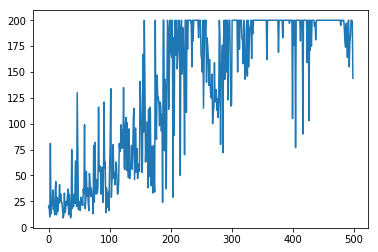

In [11]:
plt.plot(rewards)

In [12]:
p_losses, b_mses = list(zip(*losses))

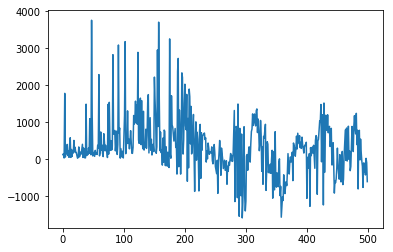

In [13]:
plt.plot(p_losses)

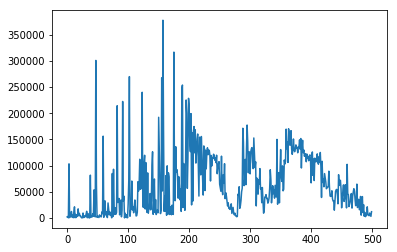

In [14]:
plt.plot(b_mses)